In [1]:
import numpy as np
import pandas as pd
import astropy.io.fits as apfits
import astropy.visualization as apvis
import astropy.nddata as apnndd
import astropy.table as aptable
import astropy.wcs as apwcs
import astropy.units as apunits
import astropy.coordinates as apcoords
import matplotlib.pyplot as mplplot
import matplotlib.patches as mplpatches
import glob
import os
import scipy as sp
import scipy.optimize as spopt
import copy
import grismconf
import sys

### Accessing Fengwu Data Files (OneDrive)

In [2]:
file_name = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_frames/jw01309025001_01101_00011_nrcb5_rate_wcs.fits"
with apfits.open(file_name) as Frame:
    module = Frame['PRIMARY'].header['MODULE'].strip()
    filter_ = Frame['PRIMARY'].header['FILTER'].strip()
    direction = Frame['PRIMARY'].header['PUPIL'].strip()[-1]

frameFitsDir = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_frames" 
frameListDir = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/ver1_F322W2_list"
frameSpec2dDir = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/extract_2d/"

#### Arrange the frames fits file list into the required format

In [3]:
# # Create full list of files within folder as a list
# frameFitsFiles = glob.glob(os.path.join(frameFitsDir, "*.fits")) 
# # Format frameFitsFiles into a dictionary

# frameFitsFiles = {
#     idx: np.sort(data.to_numpy().flatten())
#     for idx, data in pd.DataFrame(frameFitsFiles).groupby(
#         by=pd.DataFrame(frameFitsFiles)
#         .loc[:, 0]
#         .apply(lambda x: "_".join(os.path.basename(x).split("_")[:3]))
#     )
# }

#### Define functions to extract the source list, along with sky and pixel coordinates within the images

In [4]:
# Define function to extract the source list of sources within an uncalibrated image
def getSourceListForImage(image, frameListDir):
    listPath = os.path.join(
        frameListDir,
        f"{'_'.join(os.path.basename(image).split('_')[:4])}_uncal_pointsources.list",
    )
    return pd.read_csv(listPath, delim_whitespace=True, comment="#", header=None)

In [5]:
# Define function to extract the source sky coordinates of sources within an uncalibrated image
def getSourceCoordsForImage(image, frameListDir):
    sourceList = getSourceListForImage(image, frameListDir) # Use previous function within this one
    coords = apcoords.SkyCoord(
        *sourceList.loc[:, [3, 4]].to_numpy().T, frame=apcoords.ICRS, unit=apunits.deg
    )
    return coords

In [6]:
# Define function to extract the source pixel coordinates of sources within an uncalibrated image
def getSourcePixelsForImage(image, frameListDir):
    sourceList = getSourceListForImage(image, frameListDir)
    pixels = sourceList.loc[:, [5, 6]].to_numpy()
    # pixels are the 
    return pixels

### Define Function to calculate the expected trace within the image

Code taken from https://github.com/npirzkal/GRISMCONF 

In [7]:
def computeTrace(pixels, fac=100, module="A", direction="R", simYDisp=False, order=1):
    # Locate config File for the module and grism direction 
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_F322W2_mod{module}_{direction}.conf"
    # Class to read and hold GRISM configuration info
    conf = grismconf.Config(confFile)
    # Found from GRISMCONF README file - see link above
    # Middle section - number of pixels from end to start in X direction
    # 1/ middle = slighting trace by number of pixels
    # /fac is for splitting by subpixel amounts
    dt = np.abs(1 / (1 + conf.DISPX(f'+{order}', *pixels, 1) - conf.DISPX(f'+{order}', *pixels, 0)) / fac)
    t = np.arange(0, 1, dt)

    # DISP(X,Y,L) = DISPERSION POLYNOMIAL (X direction, Y, Full Length)
    # order, x0, y0, steps along dispersion between 0 and 1
    # X disp polynomial
    dxs = conf.DISPX(f"+{order}" *pixels, t)
    # Y disp polynomial 
    dys = conf.DISPY(f"+{order}" *pixels, t)
    # Compute wavelength of each pixel
    wavs = conf.DISPL(f"+{order}" *pixels, t)

    return (
        pixels[0] + dxs,
        pixels[1] + dys if simYDisp else np.full_like(dys, pixels[1]),
        wavs,
    )

In [8]:
def computeTraceWLforXpixels(pixels, module="A", direction="R", simYDisp=False, order=1):
    # Locate config File for the module and grism direction 
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_F322W2_mod{module}_{direction}.conf"
    # Class to read and hold GRISM configuration info
    conf = grismconf.Config(confFile)
    # Found from GRISMCONF README file - see link above

    
    dt = 1/(conf.DISPX(f'+{order}',*pixels,0)-conf.DISPX(f'+{order}',*pixels,1)) 
    t = np.arange(0,1,dt)

    dxs0 = conf.DISPX(f'+{order}',*pixels, 0)

    dxs1 = conf.DISPX(f'+{order}', *pixels, 1)
    
    #
    dxs = np.arange(np.floor(dxs1),np.ceil(dxs0)+1).astype(int)

    ts = conf.INVDISPX(f'+{order}',*pixels,dxs)

    wavs = conf.DISPL(f'+{order}',*pixels,ts)

    return (
        pixels[0] + dxs,
        wavs,
    )

DO WE NEED TO ADJUST THE RETURN PER DISPERSION DIRECTION??? R AND C USING DIFFERENT DXS AND DYS?

Yes but do we do this in one function or make a separate function?


In [9]:
def computeTraceBoxR(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change module depending on module used for observation
    module="A",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    height=50,
    # Set Order desired to be computed for
    order=1,
    # Need some guidance on what this is !
    **patchkws,
):
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_F322W2_mod{module}_R.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start and end of the trace
    dxs = conf.DISPX(f'+{order}', *pixels, np.array([0, 1]))
    # Keep in in case the JWST dispersion is curved and we need to trace the change in the curve
    dys = conf.DISPY(f'+{order}', *pixels, np.array([0, 1]))
    
    #Locating the centre of the trace 
    centrePix = conf.DISPX(f'+{order}', *pixels, np.array([0.5]))

    if returnRect:
#         mplplot.scatter(pixels[0]+centrePix[0], pixels[1],c='green')
        return mplpatches.Rectangle(
            # x0,y0 in bottom left of rectangle
            (pixels[0] + dxs[0], pixels[1] - height // 2),
            # width of rectangle 
            dxs[1] - dxs[0],
            # height of box (PSF width 50 pixels)
            height,
            **patchkws,
        )
    return (pixels[0]+centrePix[0], pixels[1]), (height, abs(dxs[1] - dxs[0]))

In [10]:
def computeTraceBoxC(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change module depending on module used for observation
    module="A",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    cross_disp_size=50,
    # Set Order desired to be computed for
    order=1,
    # Need some guidance on what this is !
    **patchkws,
):
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_F322W2_mod{module}_C.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start and end of the trace
    dxs = conf.DISPX(f'+{order}', *pixels, np.array([0, 1]))
    # Is the Y needed for this?
    dys = conf.DISPY(f'+{order}', *pixels, np.array([0, 1]))
    
    #Locating the centre of the trace 
    centrePix = conf.DISPY(f'+{order}', *pixels, np.array([0.5]))

    if returnRect:
#         mplplot.scatter(pixels[0]+centrePix[0], pixels[1],c='green')
        return mplpatches.Rectangle(
            # x0,y0 in bottom left of rectangle
            (pixels[0] - cross_disp_size // 2, pixels[1] + dys[0]),
            # width of rectangle 
            cross_disp_size,
            # height of box (PSF width 50 pixels)
            dys[1] - dys[0],
            **patchkws,
        )
    return (pixels[1]+centrePix[0], pixels[0]), (cross_disp_size, abs(dys[1] - dys[0]))

In [11]:
def computeTraceBox(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change module depending on module used for observation
    module="A",
    # Change Direction depending on disperser used for observation
    direction="R",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    cross_disp_size=50,
    # Set Order desired to be computed for
    order=1,
    # Need some guidance on what this is !
    **patchkws,
):
    if direction == "R":
        return computeTraceBoxR(pixels=pixels,fac=fac,module=module,simYDisp=simYDisp,returnRect=returnRect,cross_disp_size=cross_disp_size,order=order,**patchkws)
    else:
        return computeTraceBoxC(pixels=pixels,fac=fac,module=module,simYDisp=simYDisp,returnRect=returnRect,cross_disp_size=cross_disp_size,order=order,**patchkws)

In [12]:
def compute1stOrderTraceBox(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change module depending on module used for observation
    module="A",
    # Change Direction depending on disperser used for observation
    direction="R",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    cross_disp_size=50,
    # Need some guidance on what this is !
    **patchkws,
):
    return computeTraceBox(pixels,fac,module,direction,simYDisp,returnRect,cross_disp_size,1,**patchkws)

In [13]:
def compute2ndOrderTraceBox(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change module depending on module used for observation
    module="A",
    # Change Direction depending on disperser used for observation
    direction="R",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    cross_disp_size=50,
    # Need some guidance on what this is !
    **patchkws,
):
    return computeTraceBox(pixels,fac,module,direction,simYDisp,returnRect,cross_disp_size,2,**patchkws)

### Set up required variables for code
Retrieve each sources direct pixel and sky coordinates and create a Pandas dataframe of the direct pixel coords for manipulation later.

In [14]:
# Get sources from all images loaded into notebook
directPixels = getSourcePixelsForImage(file_name, frameListDir)
DPdf = pd.DataFrame(directPixels)
sourceCoords = getSourceCoordsForImage(file_name, frameListDir)

### Create dataframe of x pixels at which each source's 1st and 2nd order trace begins and ends

In [31]:
x1st = []
x2nd = []
# y = []
# print(directPixels)
for directPixel in directPixels:
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_{filter_}_mod{module}_{direction}.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start and end of the trace for 1st and 2nd order spectra
    if direction == "R":
        x1st.append(directPixel[0] + conf.DISPX("+1", *directPixel, np.array([0, 1])))
    
        x2nd.append(directPixel[0] + conf.DISPX("+2", *directPixel, np.array([0, 1])))
    
    elif direction == "C":
        x1st.append(directPixel[1] + conf.DISPY("+1", *directPixel, np.array([0, 1])))
    
        x2nd.append(directPixel[1] + conf.DISPY("+2", *directPixel, np.array([0, 1])))
    else:
        print("You have made an error. Direction must be R or C.")
    # Is the Y needed for this?
#     dys = conf.DISPY("+1", *directPixel, np.array([0, 1]))
#     dys.append(int(directPixel[1] + conf.DISPY("+1", *directPixel, np.array([0, 1]))))

dfx1st = pd.DataFrame(x1st)
display(dfx1st)
# Rename the columns for pixel trace start and endpoints
dfx1st = dfx1st.rename(columns = {0 : "low_WL", 1 : "high_WL"})
# The X and Y pixels coordinates of the sources
dfx1st["Direct_X"] = DPdf[0]
dfx1st["Direct_Y"] = DPdf[1]
# The Sky Coordinates of sources
dfx1st["RA"] = sourceCoords.ra
dfx1st["Dec"] = sourceCoords.dec
# Order of Traces
dfx1st["Order"] = 1
# Position of source with Fengwu file
dfx1st["FengwuID"] = dfx1st.index


# Dataframe sorted by trace starting furthest to the left
dfx1st = dfx1st.sort_values(by="low_WL")
# True or false to come next

dfx2nd = pd.DataFrame(x2nd)
# Rename the columns for pixel trace start and endpoints
dfx2nd = dfx2nd.rename(columns = {0 : "low_WL", 1 : "high_WL"})
# The X and Y pixels coordinates of the sources
dfx2nd["Direct_X"] = DPdf[0]
dfx2nd["Direct_Y"] = DPdf[1]
# The Sky Coordinates of sources
dfx2nd["RA"] = sourceCoords.ra
dfx2nd["Dec"] = sourceCoords.dec
# Order of Trace
dfx2nd["Order"] = 2
# Position of source with Fengwu file
dfx2nd["FengwuID"] = dfx2nd.index

# Dataframe sorted by trace starting furthest to the left
dfx2nd = dfx2nd.sort_values(by="low_WL")
dfx2nd


dfx = pd.concat([dfx2nd,dfx1st])
display(dfx[dfx["low_WL"]<0])
# dfx

0            1
0    168.691347  1911.719235
1    775.086347  2518.114235
2   1565.967347  3308.995235
3    581.679347  2324.707235
4  -1756.753653   -13.725765
..          ...          ...
70  -983.580653   759.447235
71  1410.134347  3153.162235
72   446.161347  2189.189235
73  -737.746653  1005.281235
74  1447.274347  3190.302235

[75 rows x 2 columns]

low_WL      high_WL  Direct_X  Direct_Y          RA        Dec  \
59 -1905.599653  -162.571765   680.534  -364.763  166.391188 -77.420456   
56 -1773.428653   -30.400765   567.403  -232.592  166.400438 -77.418081   
4  -1756.753653   -13.725765   813.345  -215.917  166.380346 -77.417756   
25 -1692.601653    50.426235   975.939  -151.765  166.367108 -77.416583   
23 -1691.039653    51.988235  1938.260  -150.203  166.288758 -77.416369   
8  -1608.363653   134.664235  -268.388   -67.527  166.468904 -77.415125   
64 -1397.220653   345.807235   552.046   143.616  166.401621 -77.411333   
55 -1283.894653   459.133235   724.709   256.942  166.387596 -77.409303   
24 -1125.243653   617.784235   671.385   415.593  166.391904 -77.406486   
22 -1059.799653   683.228235  1656.165   481.037  166.312492 -77.405208   
70  -983.580653   759.447235  1143.302   557.256  166.353854 -77.403942   
48  -929.092653   813.935235   674.827   611.744  166.391604 -77.403011   
65  -889.435653   853.592235  1698.015   651.401  166.309300 -77.402194   
37  -856.552653   886.475235  1556.206   684.284  166.320729 -77.401642   
11  -785.052653   957.975235   537.176   755.784  166.402667 -77.400467   
73  -737.746653  1005.281235  1244.097   803.090  166.345863 -77.399597   
17  -718.707653  1024.320235  -246.252   822.129  166.465971 -77.399225   
21  -706.868653  1036.159235   301.896   833.968  166.421596 -77.399078   
18  -643.992653  1099.035235   681.509   896.844  166.391025 -77.397981   
10  -512.869653  1230.158235  1134.425  1027.967  166.354733 -77.395658   
69  -502.750653  1240.277235  -111.007  1038.086  166.454771 -77.395428   
66  -499.273653  1243.754235   904.113  1041.563  166.373167 -77.395433   
15  -421.516653  1321.511235   958.077  1119.320  166.368854 -77.394067   
9   -339.481653  1403.546235  1737.184  1201.355  166.306671 -77.392539   
53  -280.226653  1462.801235   407.903  1260.610  166.412850 -77.391578   
61  -268.283653  1474.744235   655.885  1272.553  166.393000 -77.391383   
16  -263.430653  1479.597235   248.494  1277.406  166.425621 -77.391267   
46  -249.059653  1493.968235  -373.642  1291.777  166.475733 -77.390897   
27  -223.946653  1519.081235   580.097  1316.890  166.399046 -77.390603   
39  -143.796653  1599.231235   542.305  1397.040  166.402038 -77.389197   
14   -85.245653  1657.782235   159.300  1455.591  166.432650 -77.388128   
5    -75.518653  1667.509235  1232.824  1465.318  166.347000 -77.388000   
20   -74.471653  1668.556235   252.790  1466.365  166.425154 -77.387953   
47   -58.516653  1684.511235   -56.912  1482.320  166.449979 -77.387619   
19   -24.456653  1718.571235   345.445  1516.380  166.417712 -77.387089   
36    -0.294653  1742.733235   839.057  1540.542  166.378338 -77.386700   

    Order  FengwuID  
59      1        59  
56      1        56  
4       1         4  
25      1        25  
23      1        23  
8       1         8  
64      1        64  
55      1        55  
24      1        24  
22      1        22  
70      1        70  
48      1        48  
65      1        65  
37      1        37  
11      1        11  
73      1        73  
17      1        17  
21      1        21  
18      1        18  
10      1        10  
69      1        69  
66      1        66  
15      1        15  
9       1         9  
53      1        53  
61      1        61  
16      1        16  
46      1        46  
27      1        27  
39      1        39  
14      1        14  
5       1         5  
20      1        20  
47      1        47  
19      1        19  
36      1        36

### Plot Check of the uploaded files 

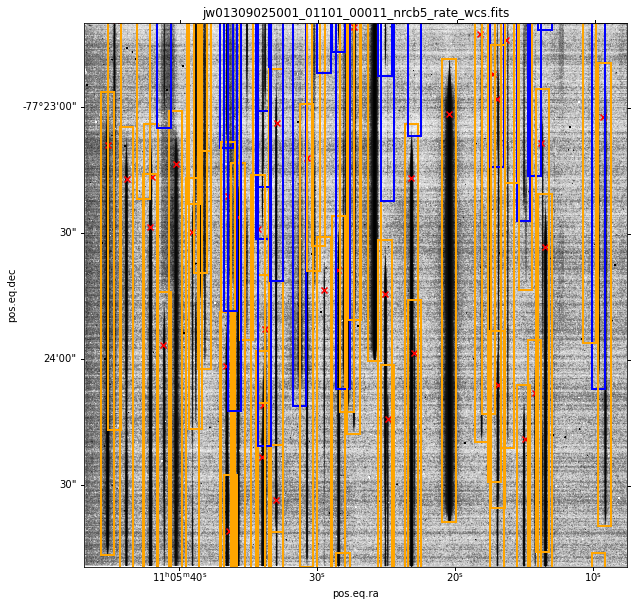

In [16]:
with apfits.open(file_name) as test:
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, projection=apwcs.WCS(test["SCI"].header))    
    ax.imshow(
        # SCI is the images from the simulation
        test["SCI"].data,
        norm=apvis.ImageNormalize(
            stretch=apvis.HistEqStretch(data=test["SCI"].data),
            interval=apvis.ZScaleInterval(),
        ),
        cmap="Greys",
    )
        
    # Set image limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
#     sourceCoords = getSourceCoordsForImage(file_name, frameListDir)
        
         # Plot sources on FOV
    ax.scatter(
        sourceCoords.ra,
        sourceCoords.dec,
        marker="x",
        c="r",
        transform=ax.get_transform("world"),
    )
    ax.set_title(os.path.basename(file_name))
        
#     directPixels = getSourcePixelsForImage(file_name, frameListDir)
#     print(file_name, directPixels[24],directPixels[77] if len(directPixels) > 50 else "Short")
        
    # for loop to create trace boxes for each source within source list
    # HOW DO WE CHANGE FOR C DIRECTION?? NEED TO LOAD C DATA???
    # where is sourceId defined? Within file_name???
    for sourceId, directPixel in enumerate(directPixels):
        traceBox1st = compute1stOrderTraceBox(
            directPixel,
            module=os.path.basename(file_name).split("_")[3][-2].upper(),
            direction="C",
            ec="orange",
            #ec="orange",
            lw="2",
            fc="none",
        )
        ax.add_patch(traceBox1st)
        
        traceBox2nd = compute2ndOrderTraceBox(
            directPixel,
            module=os.path.basename(file_name).split("_")[3][-2].upper(),
            direction="C",
            ec="blue",
            #ec="orange",
            lw="2",
            fc="none",
        )
        ax.add_patch(traceBox2nd)
        # Removing limits shows that all sources in list have traces calculated for them
        # Therefore missing traces must be due to them missing in source list which
        # will not be a problem once NIRCam Pre-imaging has been achieved
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

### Import PSF model grid modules

In [17]:
# Use source code to look into utils etc. - Ask Hugh how he knows when to look for these libraries!
from webbpsf.utils import to_griddedpsfmodel
from webbpsf.gridded_library import display_psf_grid
# How do we justify the model number (1-5??)
# Take specific instrument, module, filter and detector PSF fits files 
# and turn into a grid of how the PSF changes with position on detector array
# NUMBER OF DETECTOR IS IN NRCA5 - 5 IS LW DETECTOR 1-4 IS SW
# ONLY 5 REQUIRED FOR WFSS AS ONLY DETECTOR ABLE TO DO THIS
grid = to_griddedpsfmodel(
    f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/gridded_psf_library/nircam_nrc{module.lower()}5_{filter_.lower()}_clear_fovp47_samp5_npsf16_requirements_realization0.fits"
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-034 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-039
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


### Plot check of data within images 
In "data", the rows are the outside of the 2d array and columns on the inside - see .data[:,100] 

In [ ]:
with apfits.open(file_name) as test:
    data = test["SCI"].data
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, )#projection=apwcs.WCS(test["SCI"].header))    
#     ax.imshow(
#         # SCI is the images from the simulation
#         test["SCI"].data[:,100:101],
#         norm=apvis.ImageNormalize(
#             stretch=apvis.HistEqStretch(data=test["SCI"].data[:,100:101]),
#             interval=apvis.ZScaleInterval(),
#         ),
#         cmap="Greys",
#     )
    ax.plot(
    test["SCI"].data[100,:] if direction == "C" else test["SCI"].data[:,100] if direction =="R" else np.zero(data.shape[0]))

### Chi Squared fit function defined to find best fit parameters (Flux only at the moment not best fit Y Pixel)

In [38]:
# Chi squared function to test parameters fit
def fitFunction(norms, cutoutSlice, errorSlice, psfs, means,
#                 offsets,
                plotme=False):
#     figure = mplplot.figure(figsize = (15,15))
#     mplplot.plot(cutoutSlice, label='Cut')
#     mplplot.plot(errorSlice, label="err")
    # Error Mask to simulate likely errors when checking for what was causing incorrect fits
#     error_mask = np.ones_like(cutoutSlice)*1000
    selection = errorSlice > 0
    model = np.zeros_like(cutoutSlice)
    
#     for norm, psf, mean, offset in zip(norms, psfs, means, offsets):
    for norm, psf, mean in zip(norms, psfs, means):
        # May be better interpolated below
#         print(mean)
#         print(psf.size // 2)
#         print(model[max(0, int(mean) - psf.size // 2) : min(cutoutSlice.size, int(mean) + psf.size // 2)].size)
#         error_mask[int(mean) - psf.size // 2 : int(mean) + psf.size // 2] = 0.1
        # Model for a single column with potentially many traces passing through
        # Artificially making mean an integer - need a better approach.
        model[int(mean) - psf.size // 2 : int(mean) + psf.size // 2] += norm * psf
    
    if plotme:
        fig, ((ax1),(ax2)) = mplplot.subplots(figsize=(10,20),nrows = 2, ncols =1)
        ax1.plot(cutoutSlice, label="Data")
        ax1.plot(model,label="Initial Model")
        ax1.legend()
        ax2.plot(errorSlice)
    return np.nansum(
        ((model[selection] - cutoutSlice[selection]) / errorSlice[selection]) ** 2
    )



# Single cutout could use a defined PSF function but this is now within the code in the cell below

# def simplePsfMethod(cutout, error, psfs, xDispRange, ):
#     return[
#         spopt.minimize(
#             # parameters for function as a list in square brackets - part that varies
#             # if fitting multiple sources within box, need parameters per source
#             # This is the 'norm' within fitFunction
#             fitFunction,
#             [],
#             # Arguments - the constants 
#             (cutoutSlice[xDispRange], errorSlice[xDispRange], psfs[xDispRange]),
#         ).x[0]
#         for cutoutSlice, errorSlice in zip(cutout.T, error.T)
#     ]



list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

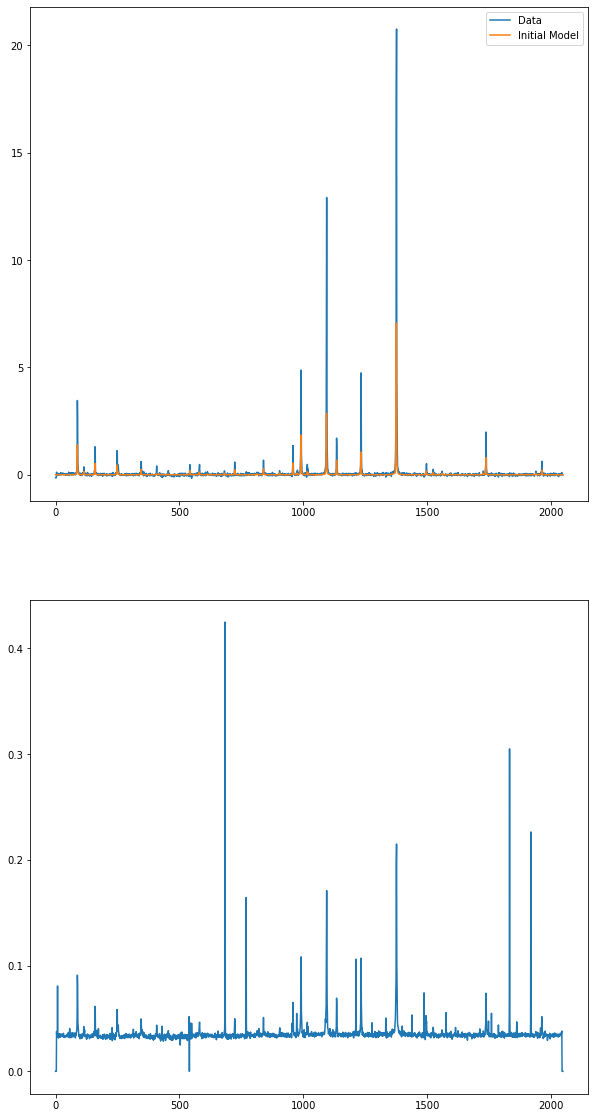

In [40]:
with apfits.open(file_name) as test:
    
    # Created array for results
    # Mask selects the sources that are within a 1/2 PSF width from edge (25 pixels)
    # as we cannot fit sources closer in than this 
    if direction == "R":
        mask = (dfx.Direct_Y >= 30) & (dfx.Direct_Y < test["SCI"].data.shape[1]-30)
        trimmed_dfx = dfx[mask.to_numpy()]
        image_data_view = enumerate(zip(test["SCI"].data.T, test["ERR"].data.T))
        initial_trace_location = trimmed_dfx.Direct_Y
    elif direction == "C":
        mask = (dfx.Direct_X >= 30) & (dfx.Direct_X < test["SCI"].data.shape[0]-30)
        trimmed_dfx = dfx[mask.to_numpy()]
        image_data_view = enumerate(zip(test["SCI"].data, test["ERR"].data))
        initial_trace_location = trimmed_dfx.Direct_X
    else:
        print("You have made an error. Set direction as R or C.")
    

#     display(trimmed_dfx1st)
    result = np.zeros(shape=(trimmed_dfx.shape[0],test["SCI"].data.T.shape[0]))
    
    # Create list for psfs used in each trace 
    # Empty list possible as we are reducing traces in order from left side of image
    # FOR B MODULE YOU WOULD START FROM RIGHT (reversed(enumerate))
    
    # Take out data per column from the image
    
    psfsForTraces = []
    fit_results = []
    all_columns_initial_params = [] 
    
    for column_number, (column, err_col) in image_data_view:

        # Step 1: Work out which and how many traces there are in column to define params
        # Want all traces with a start < 0
        # How many traces are with sensitive pixels overlap the column as a boolean list
        # Applying this mask restricts the fits to only traces within the column 
        # This results in no fit before a trace has started and after it has finished
        # This is advantagous to the fitting as it prevents parameters being fitted to noise 
        # where no signal is present. This can adversely effect the fitting of real data points 
        # as 
        if direction == "R" and module == "B":
            mask = (trimmed_dfx.high_WL <= column_number) & (trimmed_dfx.low_WL >= column_number)
        else:
            mask = (trimmed_dfx.high_WL >= column_number) & (trimmed_dfx.low_WL <= column_number)
#         print(mask.to_numpy())
#         print(trimmed_dfx.high_WL)
#         print(trimmed_dfx.low_WL)
#         print(mask.to_numpy())
#         display(trimmed_dfx1st[mask])
#         print(mask)
        # Number of traces that overlap column
        n_params = mask.sum()
#         print(n_params)
        # Created Parameter intial values to create array for function
        init_params = column[initial_trace_location[mask.to_numpy()].astype(int)]

    
        # Creating list of lists of each columns intitial parameters for each trace that the column contains
        all_columns_initial_params.append(init_params)
        
        # Step 1.5 Extract PSF for each Source
        # Setting up grid for PSF to be plotted into around central pixel of source 
        # The PSF is only given 25 pixels in each direction (N,E,S,W) of source pixel
        # Fits files use 4TRAN notation for grids (y,x) not C notation (x,y) hence 

        # Step 2: Create required number of parameters for fitting function

        # Create 1D PSF list of all sources within the mask dependent on their position in detector
        psf_list = []
        
        trimmed_dfxLowToHigh = trimmed_dfx.reset_index(drop=True)
#         display(trimmed_dfxLowToHigh)
        
        # Working from an index which orders the traces by most left, 0, to most right, 80! 
        for trace_index, (Direct_X, Direct_Y) in trimmed_dfxLowToHigh.loc[:, ["Direct_X", "Direct_Y"]].iterrows():
            
            # Step to pull PSFs required for trace position once rather than for every column
            # Saving lots of time (hopefully)
            try:
                psf_temp = psfsForTraces[trace_index]
                psf_list.append(psf_temp)
                
            except IndexError as e:
                print(e)
                
                y,x = np.mgrid[
                    int(Direct_Y - 25) : int(Direct_Y + 25),
                    int(Direct_X - 25) : int(Direct_X + 25),
                ]
#             y,x = (y,x) if direction == "R" else (x,y) if direction == "C" else (0,0)
                # Need to ask where .evaluate came from!! 
                # Seems to create 2d PSF within given parameters around central point with a given flux
                # Flux seems to be arbitrary 
                # 2D array of Y axis slices divided into X axis length list
                # Shape is (70,50) so 70 arrays with 50 flux values each!
                psf2d = grid.evaluate(
                    x=x, y=y, flux=1, x_0=int(Direct_X), y_0=int(Direct_Y)
                )
                
                # axis=1 is the y direction (cross dispersion)
                psf1d = psf2d.sum(axis=1) if direction == "R" else psf2d.sum(axis=0) if direction == "C" else np.zeros(psf2d.shape[0])
            
                psfsForTraces.append(psf1d)
                
                psf_list.append(psfsForTraces[trace_index])
        
        # Y values that match the trace locations within a slice  
        psf_means = trimmed_dfxLowToHigh.Direct_Y[mask.to_numpy()] if direction == "R" else trimmed_dfxLowToHigh.Direct_X[mask.to_numpy()] if direction == "C" else np.zeros_like(mask)
        

        # Step 3: Optimise parameters of the function given the data - Returns optimised params (Flux of each trace in column), Mean (location of source) is fixed (FOR NOW!)
        
        # ACTUAL PSF METHOD TAKING PLACE! 
        if column_number == 1000:
            _ = fitFunction(init_params, column, err_col, psf_list, psf_means, plotme=True)
            
        #Optimised parameters
        try:
            opt_result = spopt.minimize(
                    # parameters for function as a list in square brackets - part that varies
                    # if fitting multiple sources within box, need parameters per source
                    # This is the 'norm' within fitFunction
                    fitFunction,
                    copy.deepcopy(init_params),
                    # Arguments - the constants 
                    (column, err_col, psf_list, psf_means),
                    method='BFGS',
                    # HAD TO CHANGE STEP SIZE FOR MODEL TO MOVE ENOUGH TO BEGIN FITTING PROPERLY
                    # MUST HAVE BEEN TOO SMALL INITIALLY
                    options = dict(eps = 0.1),
                )
        except ValueError as e:
            print(e)
            _ = fitFunction(init_params, column, err_col, psf_list, psf_means, plotme=True)

        fit_results.append(opt_result)
        
        opt_params = opt_result.x

        # Step 4: Store Flux parameter outputs - associate flux with trace and column it belongs to!!!
        
        result[mask.to_numpy(), column_number] = opt_params
        
#         print(opt_params)
        # Step 5: Next Column please Sir
    

### Convergence Checks

Covergence Tests:
    - First check was "Status" and "message" which seemed to look okay 
    - Then checked "nit" (number of iterations the fit was performing) and saw this was mostly 0 - not fitting!
    - We plotted a single input spectra, its inital params and the fit to see that the fit and initial param spectra were basically identical
    - So originally, it looked like good fits as we initialised our values with a spectral shape 
    - Checked how errors change (made make-shift errors to ensure relatively sensible errors)
    - How many steps taken whilst fitting the initial params to the data - test whether the fit was moving
    - Created histogram of the differences between initial parameters compared to fitted - to check the fits were moving
    - Plotting fit vs initial params to check gradient is not zero (same as checking jacobians in results !!)
    

Text(0.5, 1.0, 'Fit Vs. Initial Parameters Plot ')

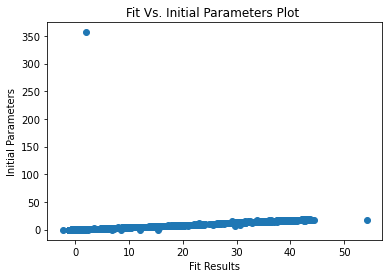

In [41]:
fit_results_1D = []
for fit_result in fit_results:
    fit_results_1D.append(fit_result.x)
    
fit_results_1D = np.concatenate(fit_results_1D)
    
all_columns_initial_params_1D = np.concatenate(all_columns_initial_params)

mplplot.scatter(fit_results_1D,all_columns_initial_params_1D)
mplplot.xlabel("Fit Results")
mplplot.ylabel("Initial Parameters")
mplplot.title("Fit Vs. Initial Parameters Plot ")

### Testing fitted Spectra against original input

RangeIndex(start=0, stop=116, step=1)

<ipython-input-55-3e105fac450c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  mplplot.figure(source)


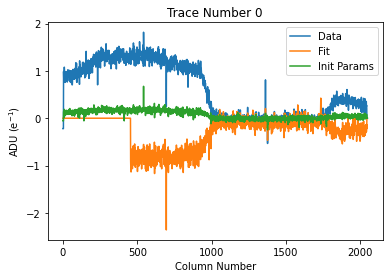

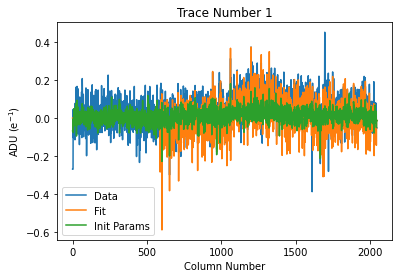

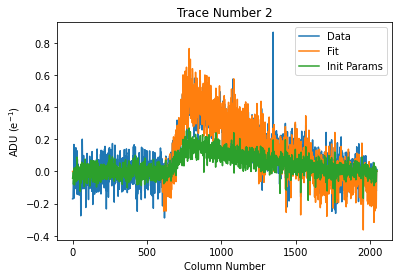

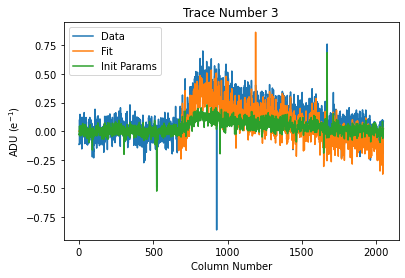

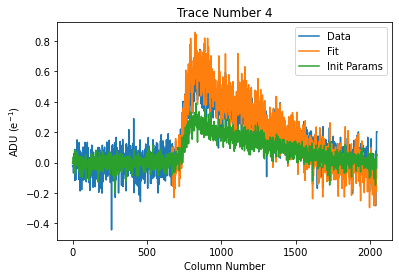

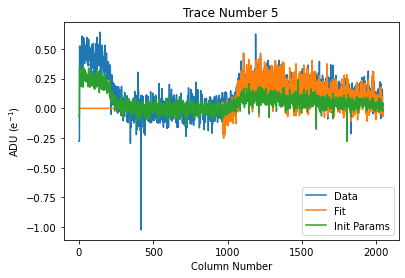

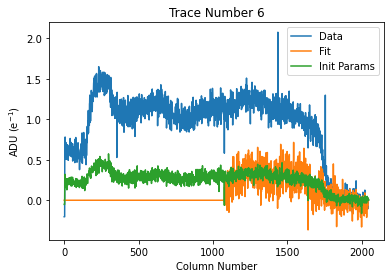

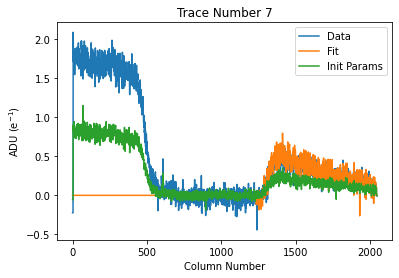

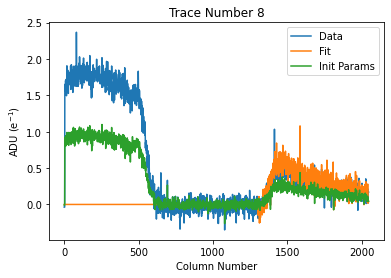

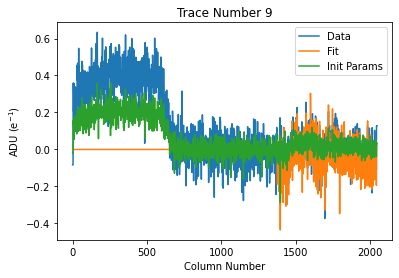

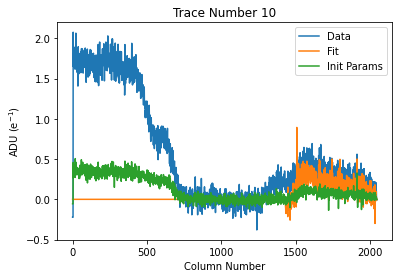

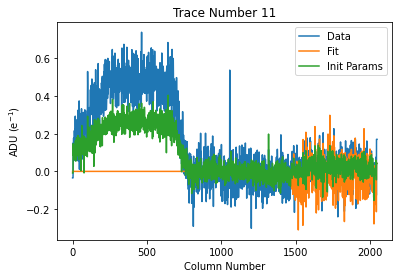

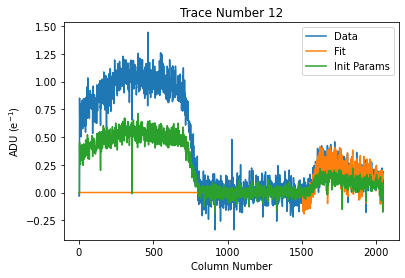

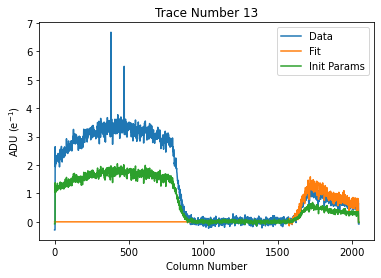

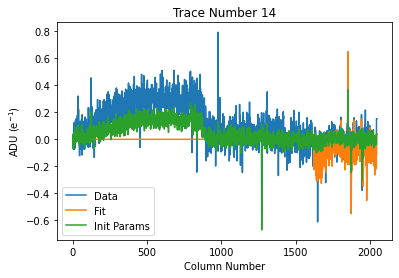

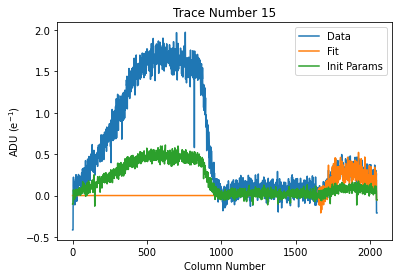

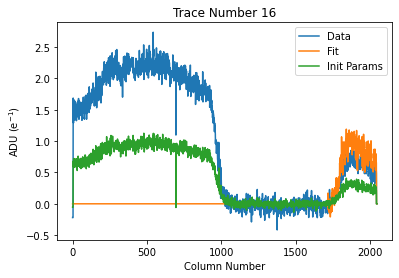

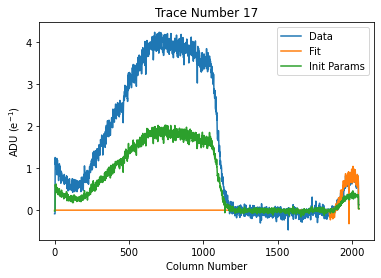

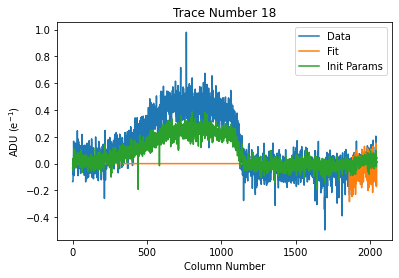

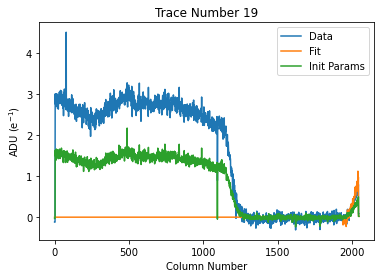

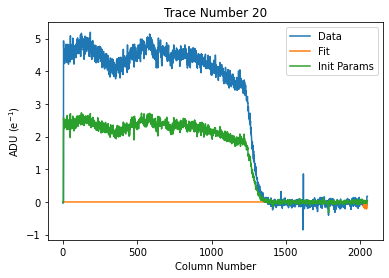

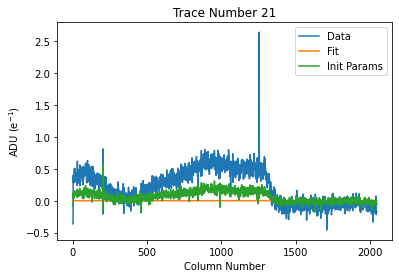

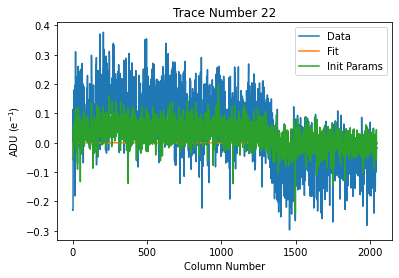

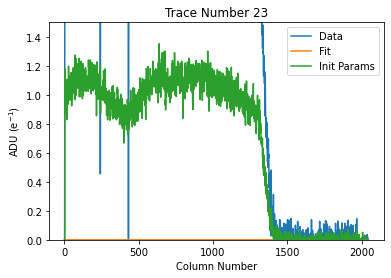

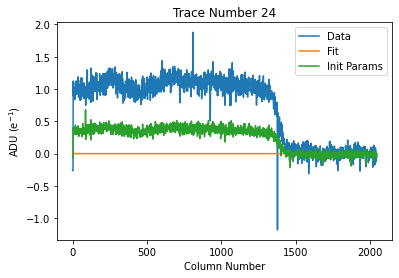

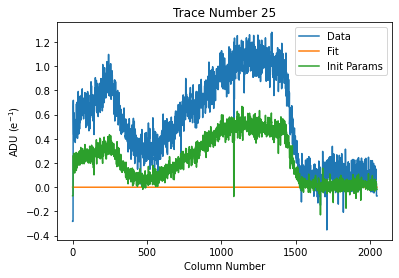

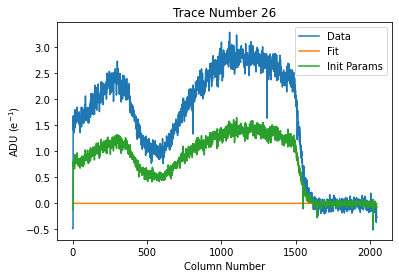

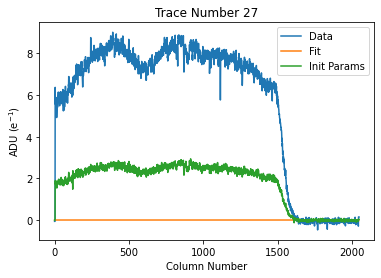

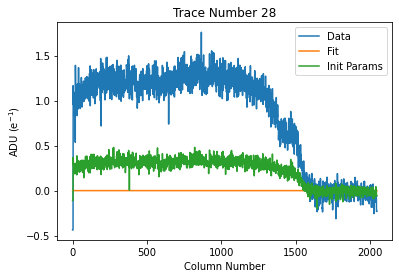

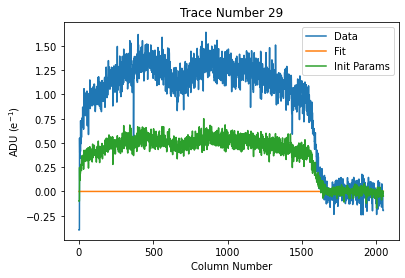

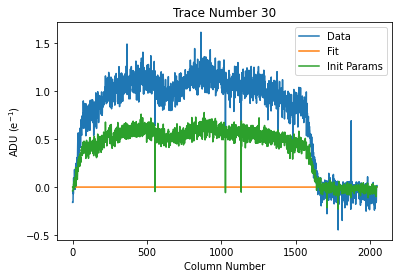

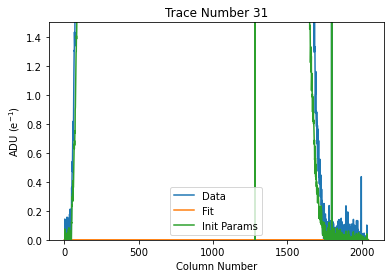

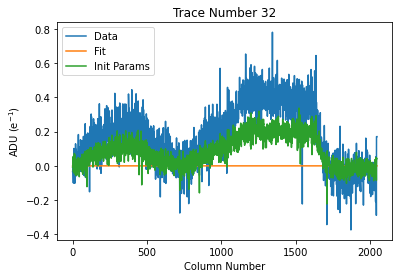

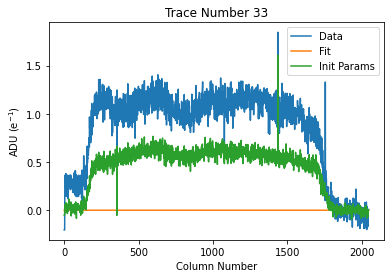

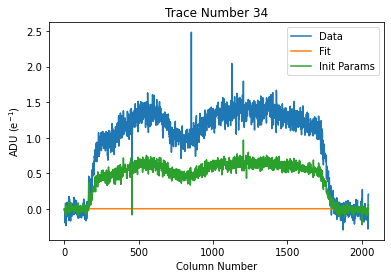

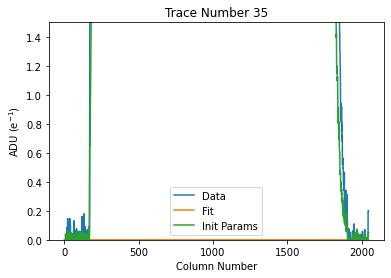

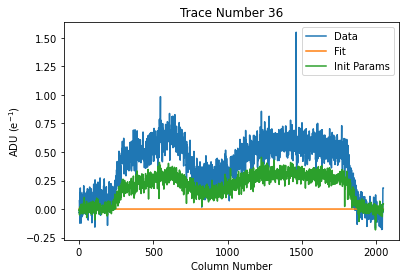

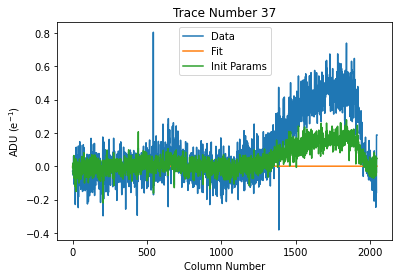

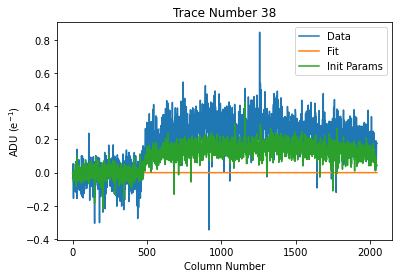

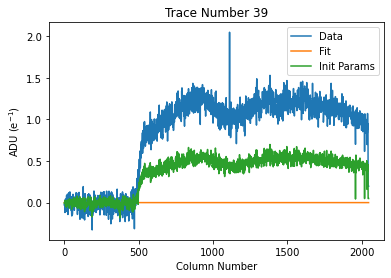

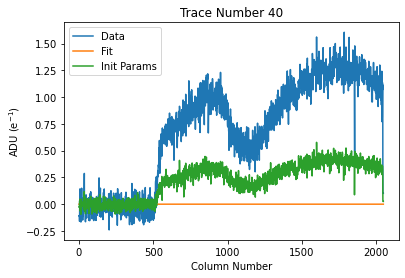

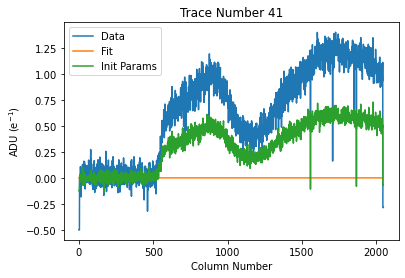

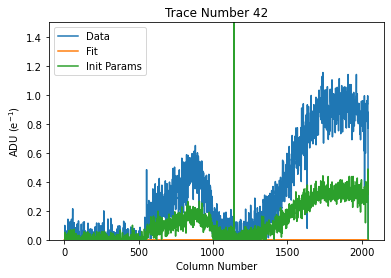

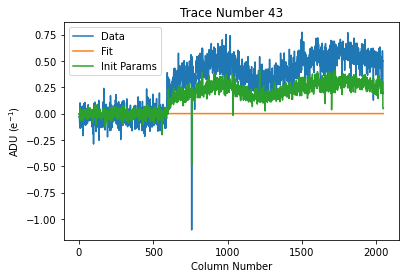

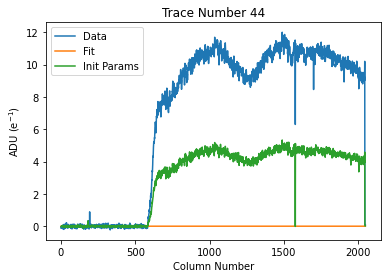

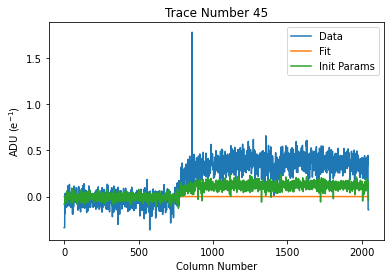

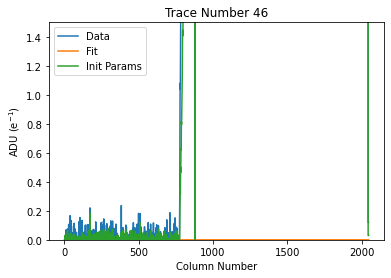

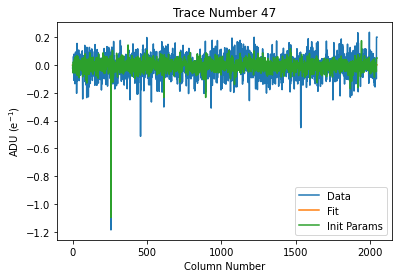

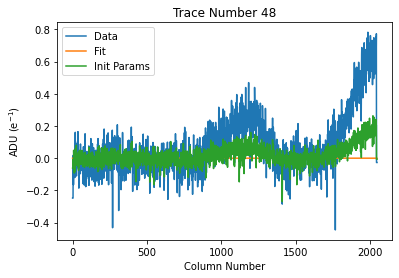

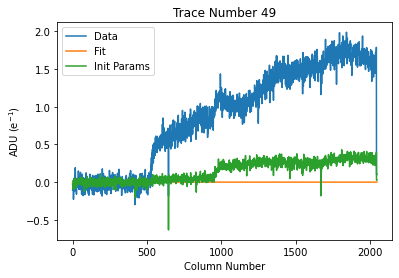

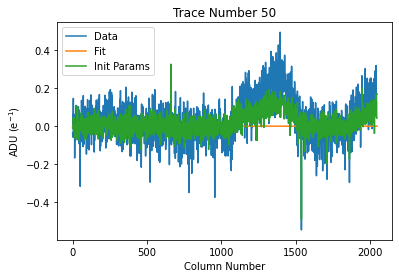

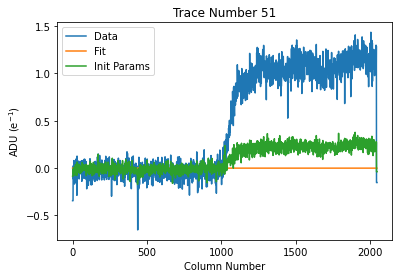

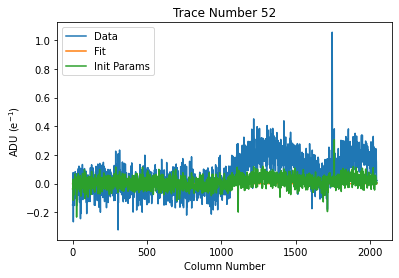

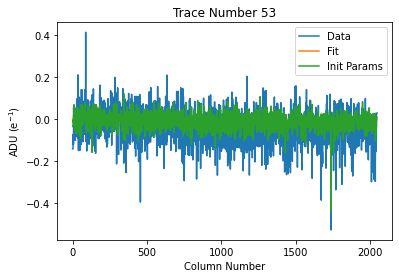

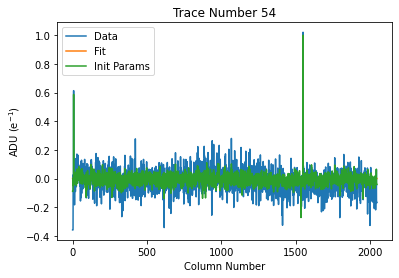

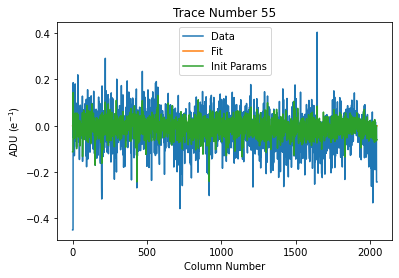

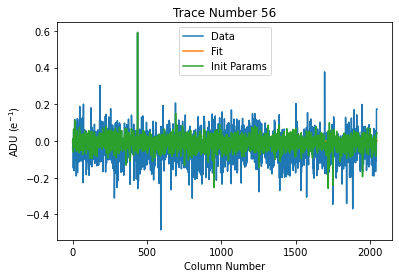

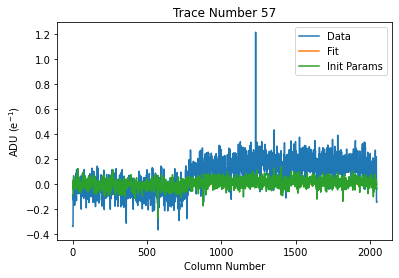

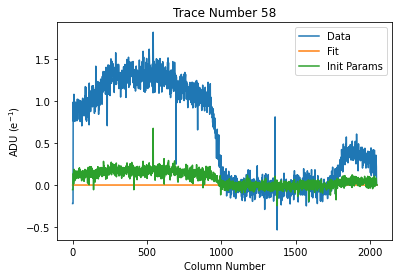

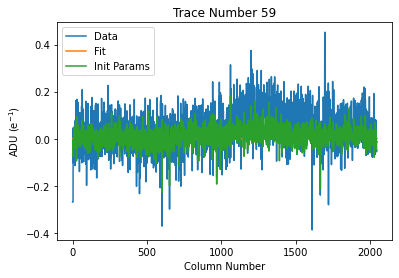

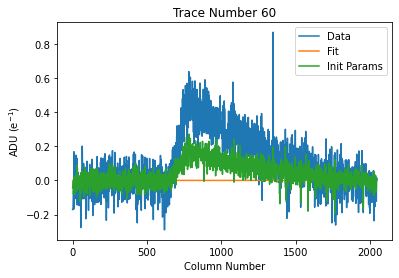

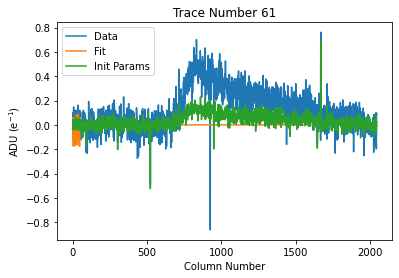

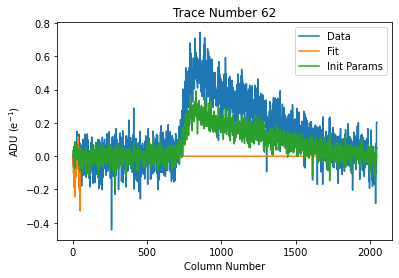

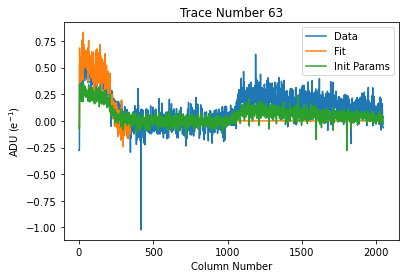

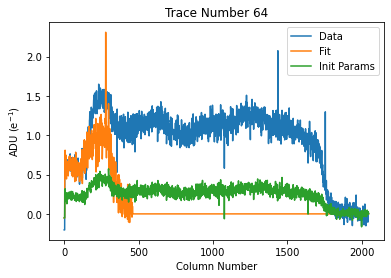

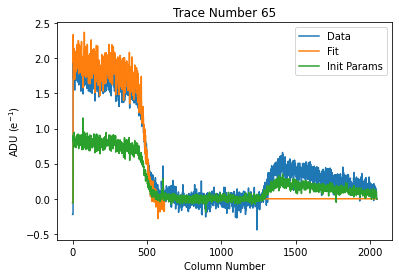

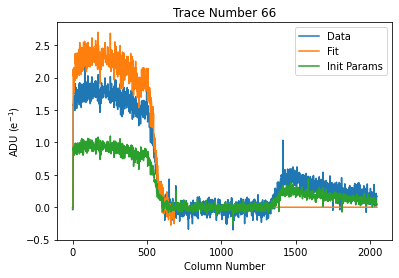

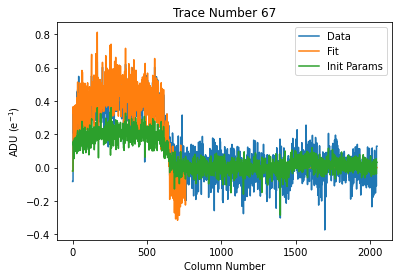

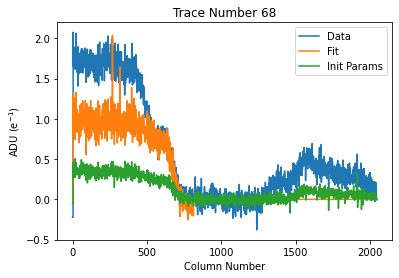

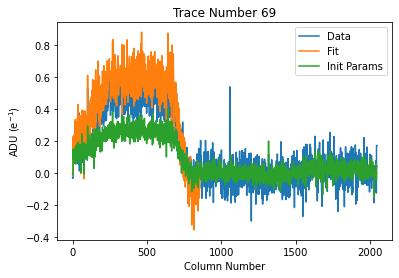

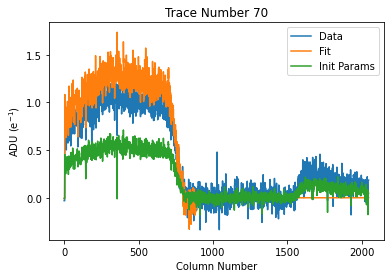

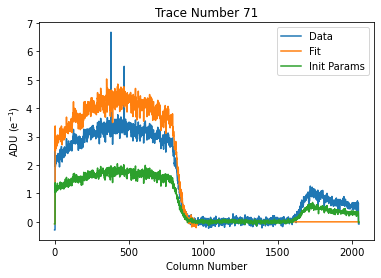

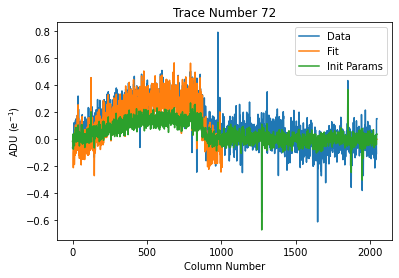

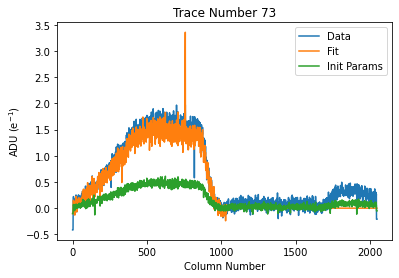

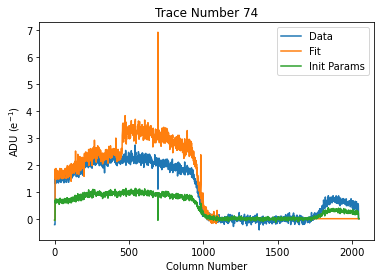

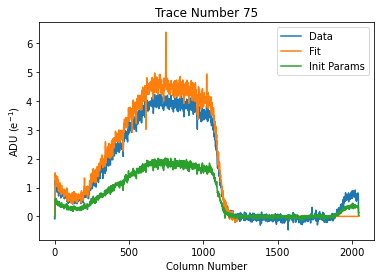

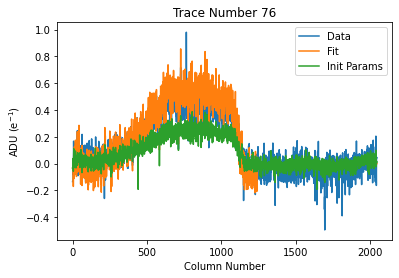

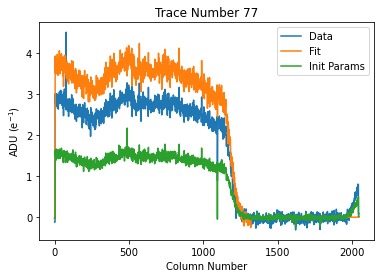

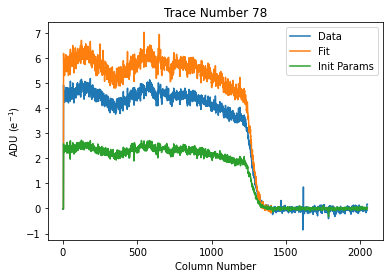

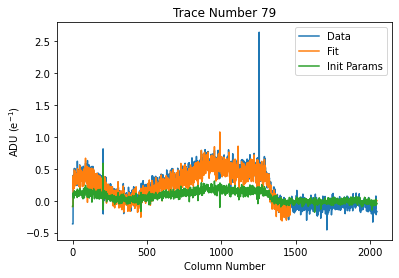

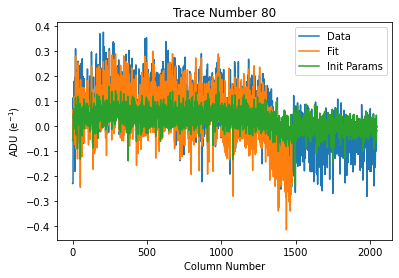

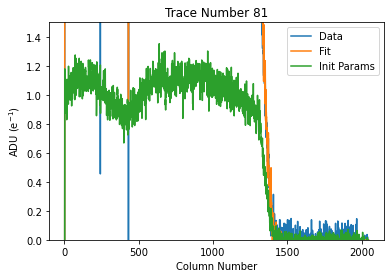

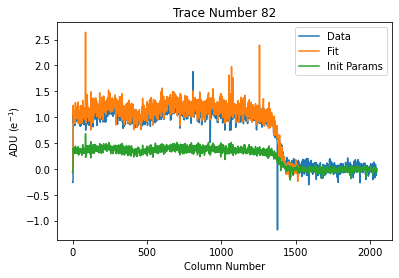

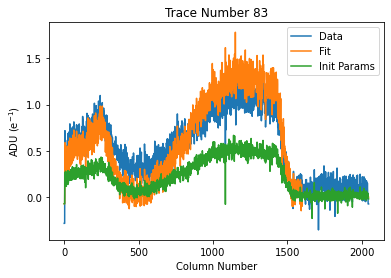

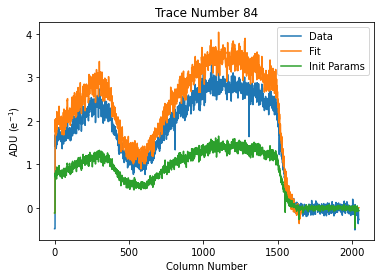

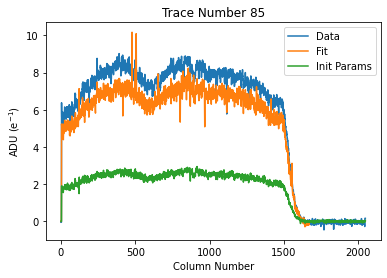

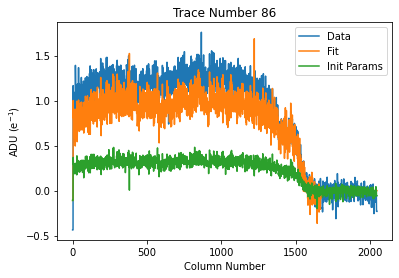

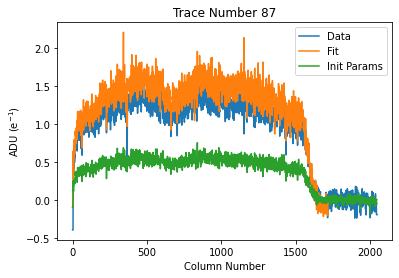

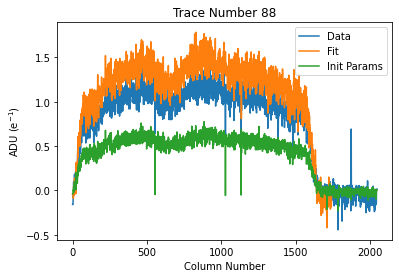

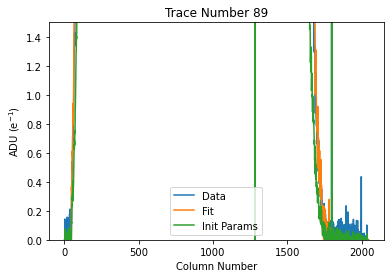

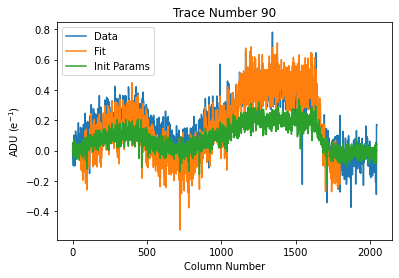

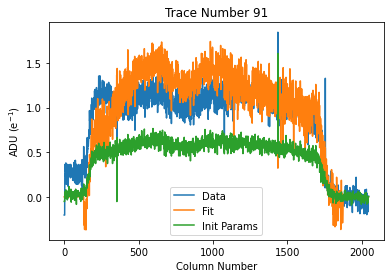

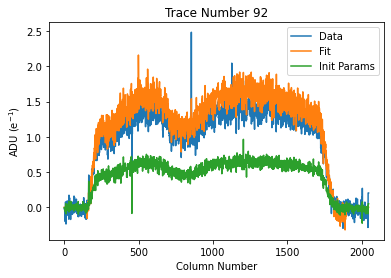

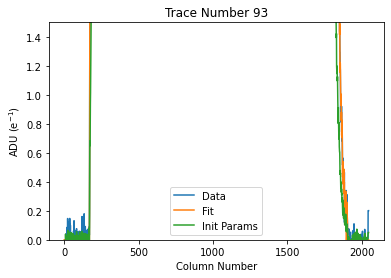

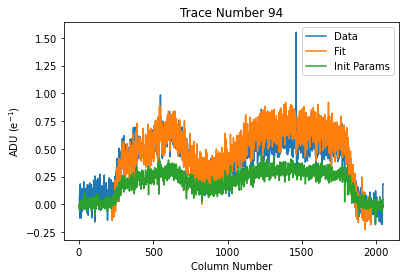

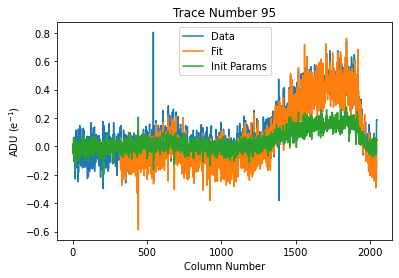

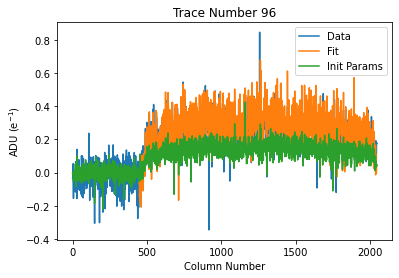

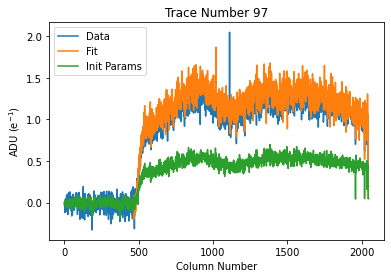

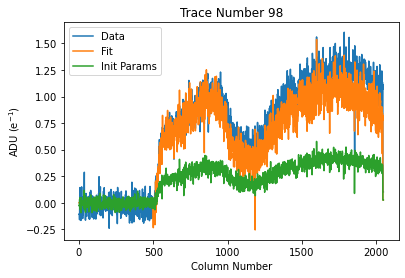

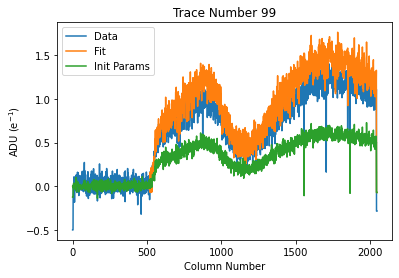

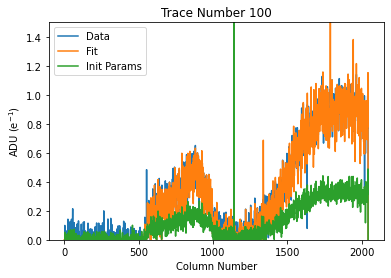

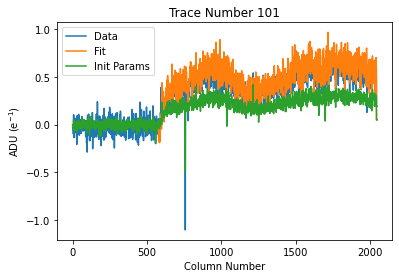

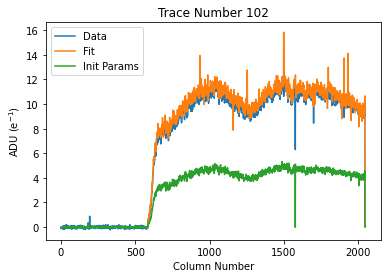

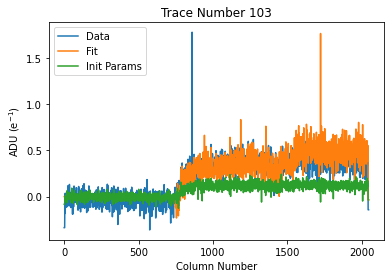

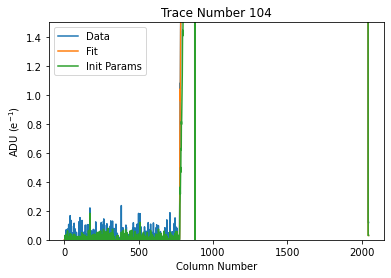

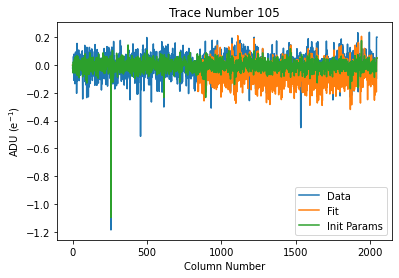

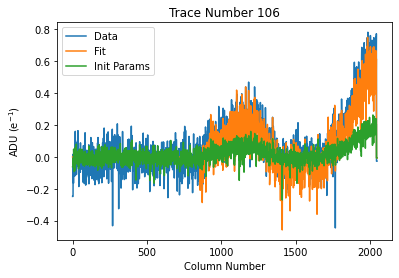

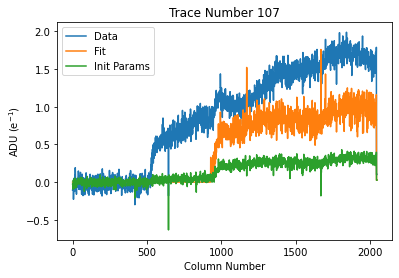

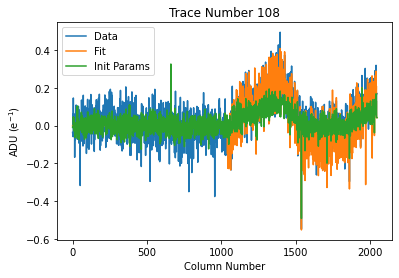

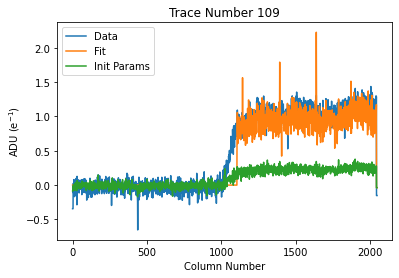

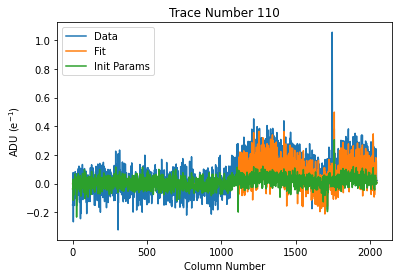

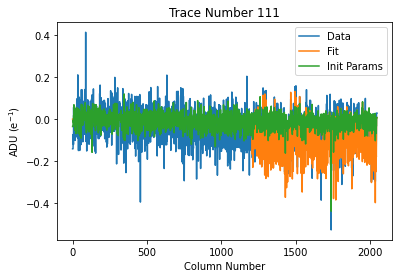

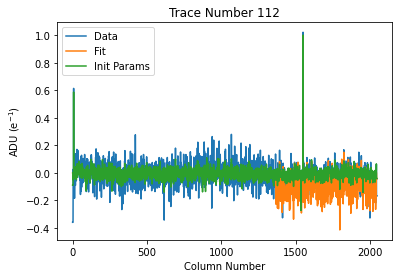

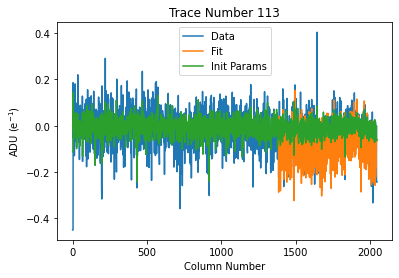

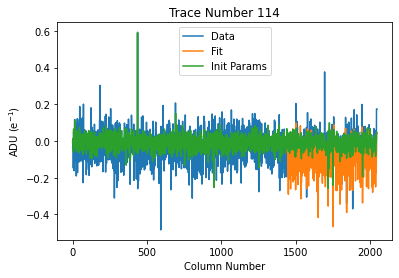

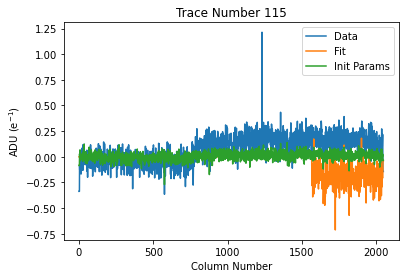

In [55]:
with apfits.open(file_name) as test:
    data = test["SCI"].data.T
    display(trimmed_dfxLowToHigh.index)
#     print(trimmed_dfx1stLowToHigh.loc[11,"Direct_Y"])
    for source in range(len(trimmed_dfxLowToHigh['Direct_X'])):
        test_trace_input_data = np.sum(data[int(trimmed_dfxLowToHigh.loc[source,"Direct_X"])-2 : int(trimmed_dfxLowToHigh.loc[source,"Direct_X"])+2],axis=0)
        mplplot.figure(source)
        mplplot.plot(test_trace_input_data, label="Data")
        mplplot.plot(result[source],label='Fit')
        mplplot.plot(data[int(trimmed_dfxLowToHigh.Direct_X[source])],label='Init Params')
        mplplot.xlabel("Column Number")
        mplplot.ylabel("ADU (e$^{-1}$)")
        mplplot.title(f"Trace Number {source}")
        mplplot.legend()
        if test_trace_input_data.max() > 20:
            mplplot.ylim(0,1.5)
# See slight differences from data to fits as fit is from 25 rows where as data is sum of 4 rows across all columns
# Sharp peak at ~1400 unknown why this is happening (could be simulated CR hit)
# Added original errors and see more sudden unexpected peaks but fit still moved from initial params

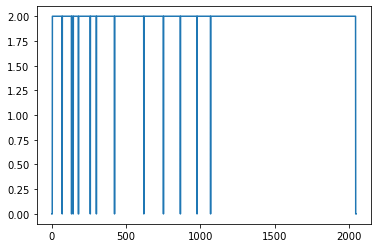

In [56]:
statuses = [result.status for result in fit_results]
cov = [result.hess_inv for result in fit_results]
# print(np.array(cov).flatten().shape)
# print(*statuses, sep='\n')
mplplot.plot(statuses)

### How many steps taken whilst fitting the initial params to the data

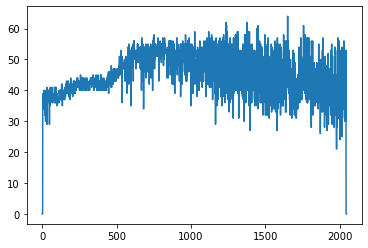

In [57]:
steps_taken = [result.nit for result in fit_results]
objective_func_value = [result.jac for result in fit_results]
# print(objective_func_value)
# The more traces there are, the more iterations required to fit each column
mplplot.plot(steps_taken)


(array([21301.,  9852., 10506.,  6197.,  1548.,  1461.,  1363.,  1260.,
         1121.,   668.,   425.,   258.,   527.,   554.,   415.,   462.,
          664.,   636.,   469.,   293.,   149.,   131.,   188.]),
 array([0.        , 0.26086957, 0.52173913, 0.7826087 , 1.04347826,
        1.30434783, 1.56521739, 1.82608696, 2.08695652, 2.34782609,
        2.60869565, 2.86956522, 3.13043478, 3.39130435, 3.65217391,
        3.91304348, 4.17391304, 4.43478261, 4.69565217, 4.95652174,
        5.2173913 , 5.47826087, 5.73913043, 6.        ]),
 <BarContainer object of 23 artists>)

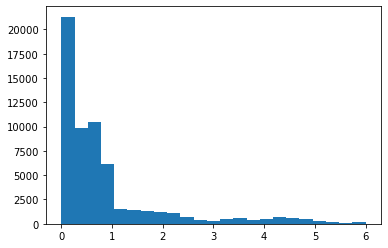

In [58]:
# List of Differences between intial parameters set for fit to the optimised results returned
init_to_opt = []
for (param, init) in zip(fit_results, all_columns_initial_params):
    for (sing_param, sing_init) in zip(param.x, init):
        init_to_opt.append(sing_param - sing_init)
mplplot.hist(init_to_opt, bins = np.linspace(0,6,24))
# Zero differences for columns with 0 traces in them

IndexError: index 77 is out of bounds for axis 0 with size 75

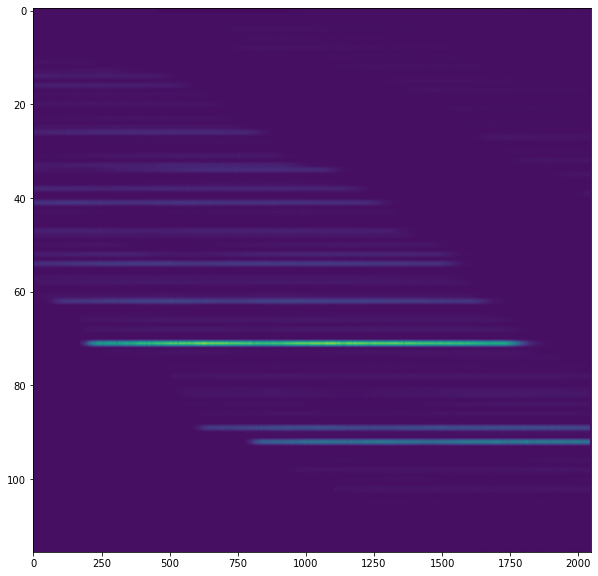

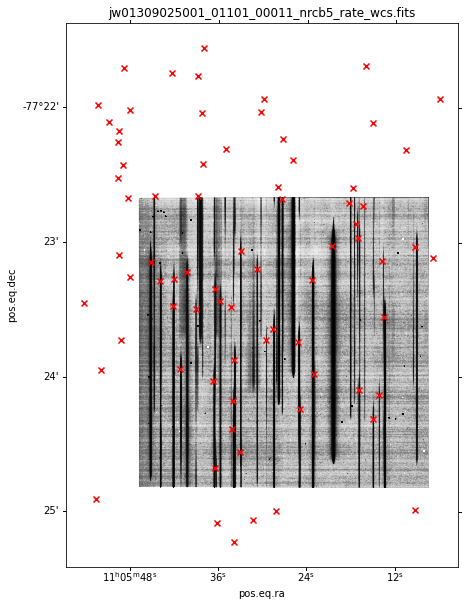

In [59]:
with apfits.open(file_name) as test:
    mplplot.figure(figsize=(10,10))
    mplplot.imshow(result[trimmed_dfxLowToHigh.sort_values("Direct_Y").index], aspect="auto")
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, projection=apwcs.WCS(test["SCI"].header))    
    ax.imshow(
        # SCI is the images from the simulation
        test["SCI"].data,
        norm=apvis.ImageNormalize(
            stretch=apvis.HistEqStretch(data=test["SCI"].data),
            interval=apvis.ZScaleInterval(),
        ),
        cmap="Greys",
    )
    # Set image limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    ax.scatter(
        sourceCoords.ra,
        sourceCoords.dec,
        marker="x",
        c="r",
        transform=ax.get_transform("world"),
    )
    ax.set_title(os.path.basename(file_name))
        
#     directPixels = getSourcePixelsForImage(file_name, frameListDir)
    print(file_name, directPixels[24],directPixels[77] if len(directPixels) > 50 else "Short")
        
    # for loop to create trace boxes for each source within source list
    # HOW DO WE CHANGE FOR C DIRECTION?? NEED TO LOAD C DATA???
    # where is sourceId defined? Within file_name???
    for sourceId, directPixel in enumerate(directPixels):
        traceBox1st = compute1stOrderTraceBox(
            directPixel,
            module=os.path.basename(file_name).split("_")[3][-2].upper(),
            direction="R",
            ec="orange",
            #ec="orange",
            lw="2",
            fc="none",
        )
        
        traceBox2nd = compute2ndOrderTraceBox(
            directPixel,
            module=os.path.basename(file_name).split("_")[3][-2].upper(),
            direction="R",
            ec="blue",
            #ec="orange",
            lw="2",
            fc="none",
        )
        
        ax.add_patch(traceBox1st)
#         ax.add_patch(traceBox2nd)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

## NEED to adjust position of applying sensitivity model for each source 

In [60]:
SensFile = apfits.open(f"GRISM_NIRCAM/V2/NIRCam.{filter_}.{direction}.{module}.1st.sensitivity.fits")
# print(repr(SensFile[1].header)) # Units check
SensTable = aptable.Table(SensFile[1].data)
SensData_WL = SensTable[0][:]
SensData_Sens = SensTable[1][:]
SensData_Er = SensTable[2][:]

print((SensData_WL.min(),SensData_WL.max()))

# Set up the Spectral Response Function Curve to perform Flux calibration (from ADU to Flux)
# fill_value = extrapolate required as the 2 wavelength ranges do not match
SRFCurve = sp.interpolate.interp1d(SensData_WL,SensData_Sens,kind='cubic',fill_value="extrapolate")

SRFCurves = {1: SRFCurve}

mplplot.plot(SensData_WL,SRFCurve(SensData_WL))


FileNotFoundError: [Errno 2] No such file or directory: 'GRISM_NIRCAM/V2/NIRCam.F322W2.C.B.1st.sensitivity.fits'

In [ ]:
SensFile = apfits.open(f"GRISM_NIRCAM/V2/NIRCam.{filter_}.{direction}.{module}.2nd.sensitivity.fits")
# print(repr(SensFile[1].header)) # Units check
SensTable2nd = aptable.Table(SensFile2nd[1].data)
SensData_WL2nd = SensTable2nd[0][:]
SensData_Sens2nd = SensTable2nd[1][:]
SensData_Er2nd = SensTable[2][:]

print((SensData_WL2nd.min(),SensData_WL2nd.max()))

# Set up the Spectral Response Function Curve to perform Flux calibration (from ADU to Flux)
# fill_value = extrapolate required as the 2 wavelength ranges do not match
SRFCurve2nd = sp.interpolate.interp1d(SensData_WL2nd,SensData_Sens2nd,kind='cubic',fill_value="extrapolate")

SRFCurves.update({2:SRFCurve2nd})

mplplot.plot(SensData_WL2nd,SRFCurve2nd(SensData_WL2nd))

In [ ]:
resultSensCurve = np.zeros_like(result)
trace_WLs_list = []
trace_x_pixels_indexes = []

firstPrinted = False
secondPrinted = False

for res_index, res in enumerate(result):
    
    order = trimmed_dfxLowToHigh.Order[res_index]
    trace = computeTraceWLforXpixels(
            (trimmed_dfxLowToHigh.Direct_X[res_index], trimmed_dfxLowToHigh.Direct_Y[res_index]),
            module=os.path.basename(file_name).split("_")[3][-2].upper(),
            direction="R",
    )
    # Temporary check that second order wavelength step per pixel is smaller
    # remove once verified.
    if order == 1 and not firstPrinted:
        print(order)
        print(trace[1]-trace[0])
    elif order == 2 and not secondPrinted:
        print(order)
        print(trace[1]-trace[0])

#     print(trace[0])
    trace_x_pixels = trace[0][(trace[0]>=0) & (trace[0]<2048)].astype(int)
    trace_x_pixels_indexes.append(trace_x_pixels)
    
    trace_WLs = trace[1][(trace[0]>=0) & (trace[0]<2048)]
    trace_WLs_list.append(trace_WLs)
#     print(trace_WLs,trace_WLs.shape)
    
#     try:
#         print(trace_x_pixels.min(),trace_x_pixels.max())
#     except:
#         print(trace_x_pixels)
    
#     print(len(trace_x_pixels))
    
    resultSensCurve[res_index,trace_x_pixels] = SRFCurves[order](trace_WLs)
    
mplplot.figure(figsize=(10,10))
mplplot.imshow(resultSensCurve[trimmed_dfxLowToHigh.sort_values("Direct_Y").index], aspect="auto")

calibratedFlux = result/resultSensCurve


mplplot.figure(figsize=(10,10))
mplplot.imshow(calibratedFlux[trimmed_dfxLowToHigh.sort_values("Direct_Y").index], aspect="auto",
               norm=apvis.ImageNormalize(
                stretch=apvis.HistEqStretch(data=calibratedFlux[trimmed_dfxLowToHigh.sort_values("Direct_Y").index]),
                interval=apvis.ZScaleInterval(),
        ))
    

In [ ]:
print(len(trimmed_dfxLowToHigh))
display(trimmed_dfxLowToHigh)

## NEED to adjust position of applying sensitivity model for each source 

In [ ]:
for position, sub_result in enumerate(calibratedFlux):
    mplplot.figure(figsize=(9,9))
    wavelengths = trace_WLs_list[position]
    wavelengths_mask = (wavelengths>=2.5) & (wavelengths<3.9)
    mplplot.plot(wavelengths[wavelengths_mask], sub_result[trace_x_pixels_indexes[position]][wavelengths_mask])
    
    mplplot.title(f"Trace Number {position}")
    mplplot.xlabel('$\lambda$ / $\mu$m')
    mplplot.ylabel('Flux / erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$' )